# Active Learning for Text Classification using Small-Text: Stopping Criteria

*Notebook 2*  
This tutorial shows how to use stopping criteria when performing active learning for text classification using [small-text](https://github.com/webis-de/small-text). If you have read the previous notebCriterionook already, you can also directly jump to the [relevant section regarding stopping criteria](#nb2-part4-stopping).

----

## Overview

- [Part I: Installation](#nb2-part1-installation)
- [Part II: Loading and Preparing the Data](#nb2-part2-data)
- [Part III: Active Learning](#nb2-part3-active-learning)
- [Part IV: Stopping Criterion](#nb2-part4-stopping)
- [Part V: Visualization](#nb2-part5-visualization)

----
<a id="nb2-part1-installation"></a>
## I. Installation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
# until the next release: install small-text from dev branch 
%pip install git+https://github.com/webis-de/small-text.git@dev#egg=small-text[transformers]
#%pip install small-text[transformers]==1.1.1   # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

  Cloning https://github.com/webis-de/small-text.git (to revision dev) to /tmp/pip-install-qszp8p33/small-text_40dec0551da04e90a5236d224cddce6e
  Running command git clone --filter=blob:none --quiet https://github.com/webis-de/small-text.git /tmp/pip-install-qszp8p33/small-text_40dec0551da04e90a5236d224cddce6e
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/webis-de/small-text.git to commit 5edee70c64dbb2ecf103dc8775f62b1339fa8c9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


The code in the following cell sets the logging level and progress bars to make it suitable for notebooks. Moreover, we set a fixed random seed, so you get the same output every time you run this notebook.

In [2]:
import datasets
import torch

import numpy as np

from matplotlib import rcParams

datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

# set matplotlib params
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

# fix the random seed
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

<a id="nb2-part2-data"></a>
## II. Loading and Preparing the Data

Again, we load the rotten tomatoes dataset and build a TransformersDataset object which is then used for active learning.

In [3]:
import logging
import numpy as np


from transformers import AutoTokenizer

from small_text import TransformersDataset


raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = raw_dataset['train'].features['label'].num_classes

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)


target_labels = np.arange(num_classes)

train = TransformersDataset.from_arrays(raw_dataset['train']['text'],
                                        raw_dataset['train']['label'],
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       raw_dataset['test']['label'],
                                       tokenizer,
                                       max_length=60,
                                       target_labels=target_labels)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 655.16it/s]
/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


----

<a id="nb2-part3-active-learning"></a>
## III. Active Learning

Now we setup a tranformer-based active learning process.

In [4]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

----

<a id="nb2-part4-stopping"></a>
## IV. Stopping Criterion

Besides, we slightly change the evaluation: In order to make the setting more realistic, we do not evaluate on the test accuracy any longer, since you will not have a test set in real-world situations. 

Unlike before, we now also output the stopping response (True or False). The stopping criteria are not bound to the PoolBasedActiveLearner class because in real-world applications a user should have the final say whether the active learning process is stopped or not. Stopping criteria are intended to be an indicator, whose recommendation can be accepted or rejected.

In [5]:
from sklearn.metrics import accuracy_score
from small_text import KappaAverage


num_queries = 15
stopping_criterion = KappaAverage(num_classes, kappa=0.9)


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    # Notice: We observe the train accuracy now.
    train_acc = accuracy_score(y_pred, train.y)

    print('Train accuracy: {:.2f}'.format(train_acc))
    print('Test accuracy: {:.2f}'.format(accuracy_score(y_pred_test, test.y)))
    
    return train_acc


results = []
stopping_history = []

results.append(evaluate(active_learner, train[indices_labeled], test))
stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))
    
    stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
    print(f'Stop: {stopping_criterion_response}')
    stopping_history.append(stopping_criterion_response)
 

Train accuracy: 0.60
Test accuracy: 0.49
---------------
Iteration #0 (40 samples)
Train accuracy: 0.93
Test accuracy: 0.63
Stop: False
---------------
Iteration #1 (60 samples)
Train accuracy: 0.98
Test accuracy: 0.64
Stop: False
---------------
Iteration #2 (80 samples)
Train accuracy: 0.97
Test accuracy: 0.68
Stop: False
---------------
Iteration #3 (100 samples)
Train accuracy: 0.66
Test accuracy: 0.52
Stop: False
---------------
Iteration #4 (120 samples)
Train accuracy: 0.94
Test accuracy: 0.70
Stop: False
---------------
Iteration #5 (140 samples)
Train accuracy: 0.96
Test accuracy: 0.71
Stop: False
---------------
Iteration #6 (160 samples)
Train accuracy: 0.98
Test accuracy: 0.74
Stop: False
---------------
Iteration #7 (180 samples)
Train accuracy: 0.94
Test accuracy: 0.77
Stop: False
---------------
Iteration #8 (200 samples)
Train accuracy: 0.97
Test accuracy: 0.76
Stop: True
---------------
Iteration #9 (220 samples)
Train accuracy: 0.95
Test accuracy: 0.77
Stop: True
----

----

<a name="nb2-part5-visualization"></a>
## V. Visualization

You can use the learning curve plot, which now depicts the learning curve of the training accuracy, to visualize the earliest iteration at which the stopping criterion returned `True`.

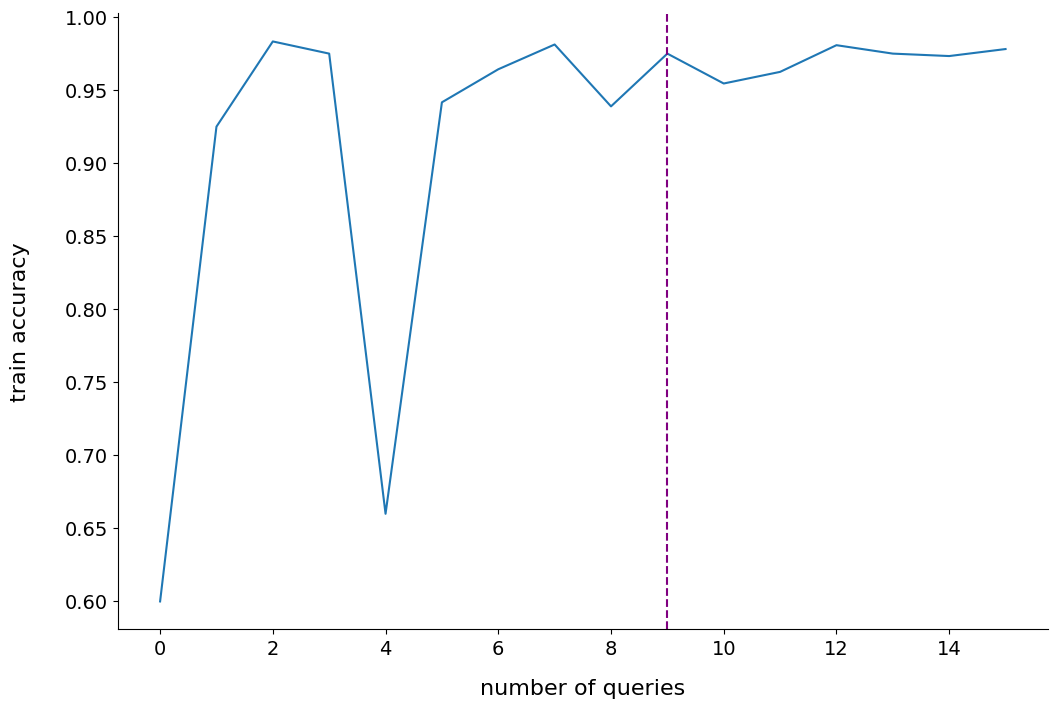

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('train accuracy', labelpad=25)

earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

sns.despine()